In [37]:
import pandas as pd
import pickle
import pathlib
import seaborn as sns
import numpy as np
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt

In [38]:
curr_dir = pathlib.Path.cwd()
home_dir = curr_dir.parent
raw_path = home_dir.as_posix() 
insights_plot_path = raw_path  + r'/src/visualization/insights_plots/'

In [39]:
file_path = raw_path + r'\pickle_files\flight_pipeline.pkl'
with open(file_path, 'rb') as file:
    pipeline = pickle.load(file)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['round_trip_duration',
                                                   'Days_to_Fly',
                                                   'flight_duration_value']),
                                                 ('cat', OneHotEncoder(),
                                                  ['carrier', 'Trip_Type',
                                                   'Airport_Route', 'stop',
                                                   'Holiday', 'from_hour',
                                                   'Fly_WeekDay'])])),
                ('regressor', RandomForestRegressor())])

In [40]:
file_path = raw_path + r'\pickle_files\flight_df.pkl'
with open(file_path, 'rb') as file:
    df = pickle.load(file)
df

,Unnamed: 0,carrier,Trip_Type,Airport_Route,stop,round_trip_duration,Days_to_Fly,from_hour,flight_duration_value,Holiday,Fly_WeekDay,price
0,0,Spirit,Rounds Trip,EWR - LAX,Nonstop,89,18,06:45,6.5,Not_Holiday,4,211.0
1,1,Alaska,Rounds Trip,EWR - LAX,Nonstop,89,18,07:30,6.3,Not_Holiday,4,297.0
2,2,JetBlue,Rounds Trip,EWR - LAX,Nonstop,89,18,05:15,6.2,Not_Holiday,4,298.0
3,3,United,Rounds Trip,EWR - LAX,Nonstop,89,18,12:00,6.4,Not_Holiday,4,302.0
7,7,United,Rounds Trip,EWR - LAX,Nonstop,89,18,07:00,6.2,Not_Holiday,4,309.0
...,...,...,...,...,...,...,...,...,...,...,...,...
138978,140441,Alaska,One Way,LAX - EWR,Nonstop,0,89,10:15,5.6,Holiday,4,259.0
138979,140442,JetBlue,One Way,LAX - EWR,Nonstop,0,89,11:15,5.5,Holiday,4,259.0
138980,140443,Delta,One Way,LAX - JFK,Nonstop,0,89,06:00,5.6,Holiday,4,274.0
138981,140444,Delta,One Way,LAX - JFK,Nonstop,0,89,09:15,5.9,Holiday,4,274.0


saving carrier


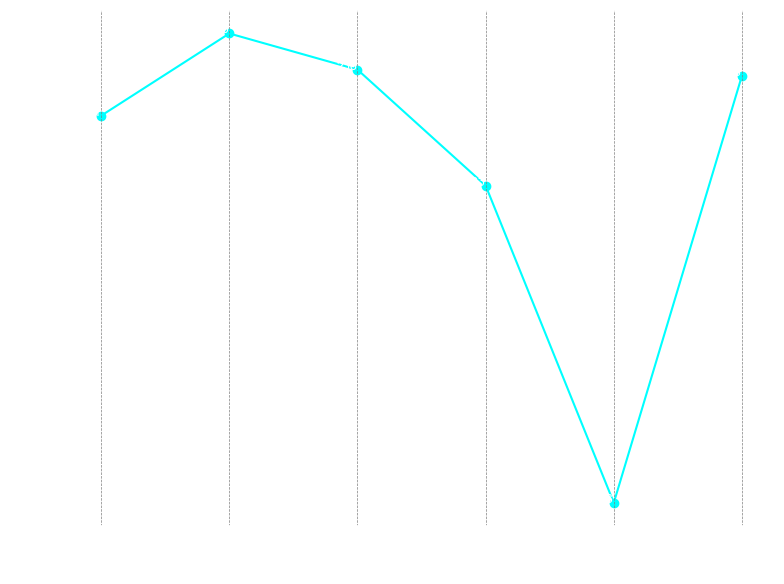

saving Airport_Route


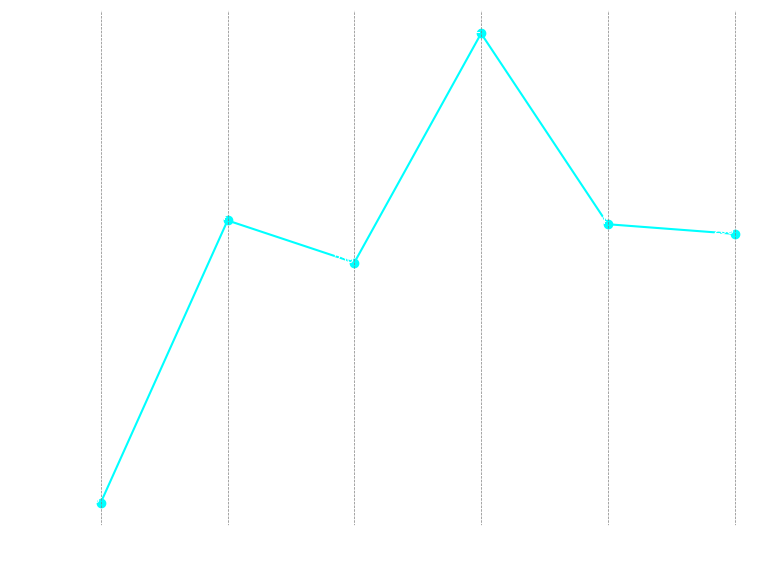

saving stop


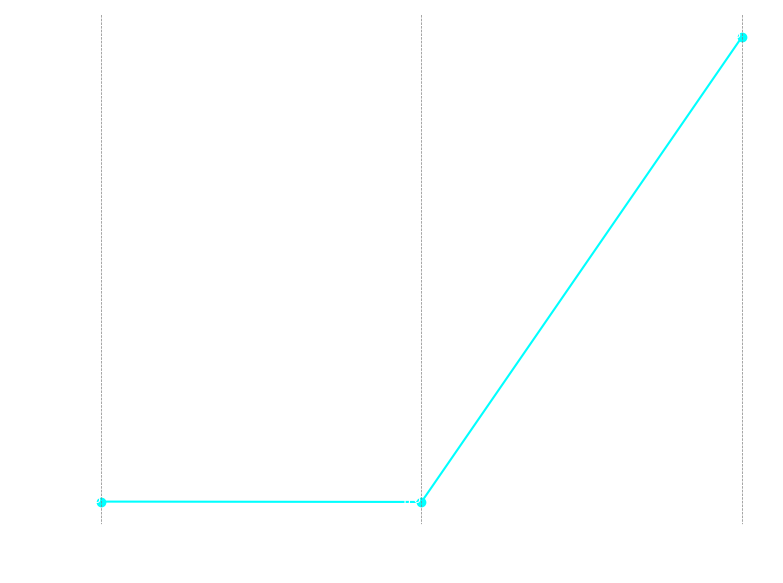

saving Days_to_Fly


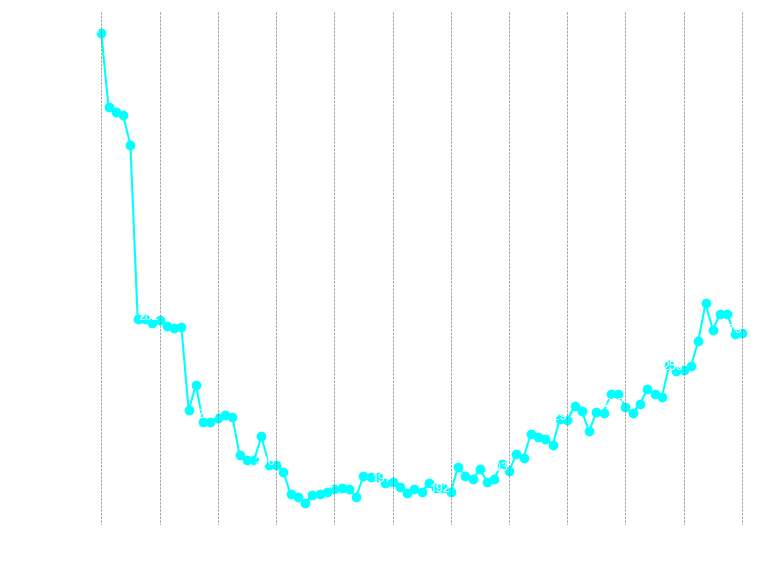

saving from_hour


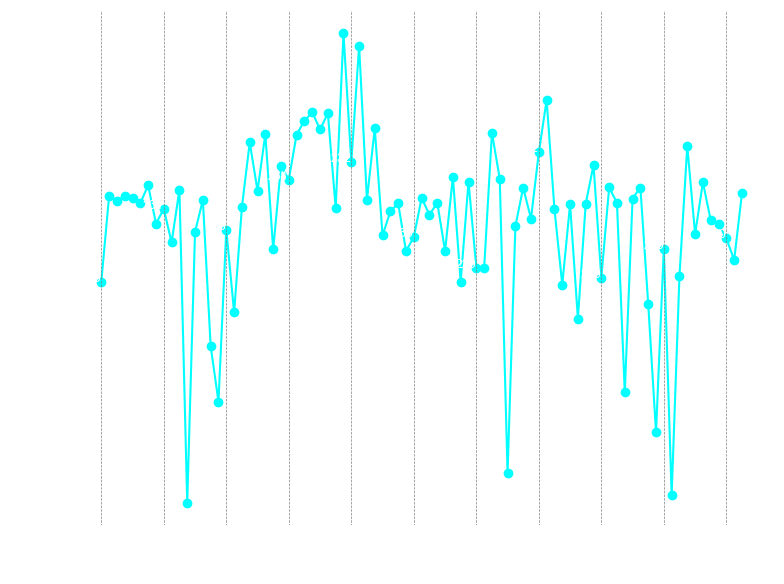

saving flight_duration_value


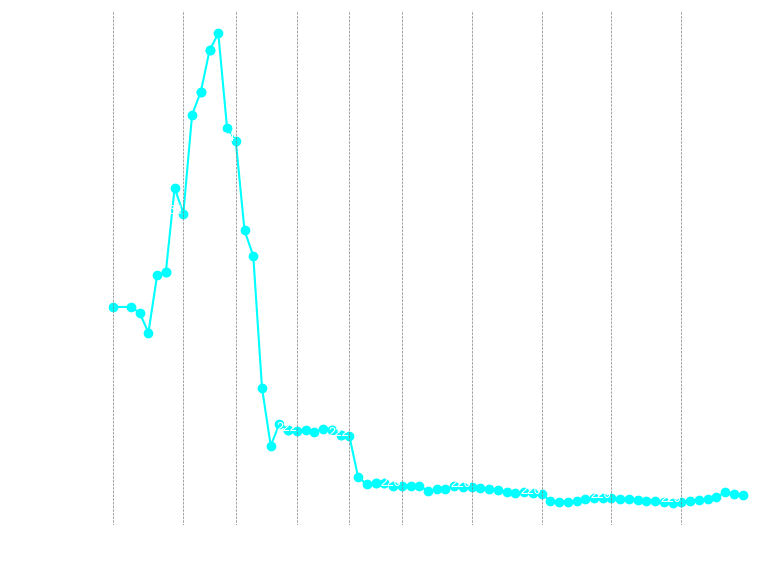

saving Holiday


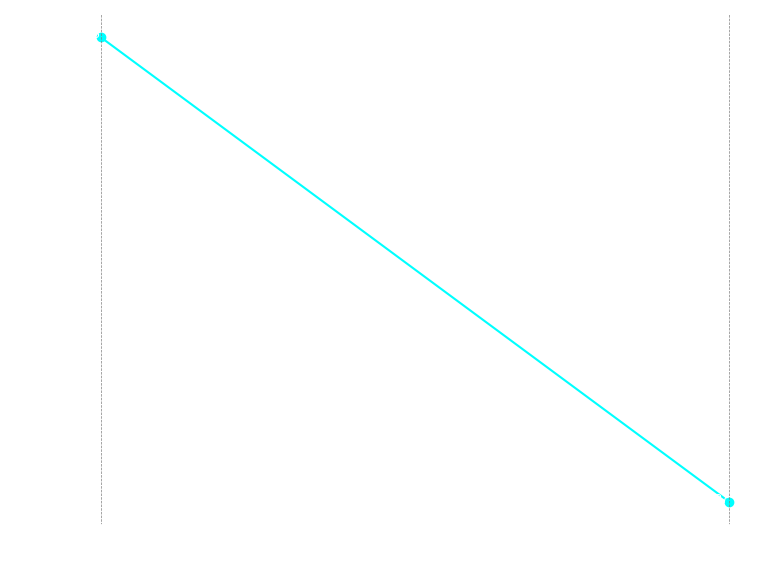

saving Fly_WeekDay


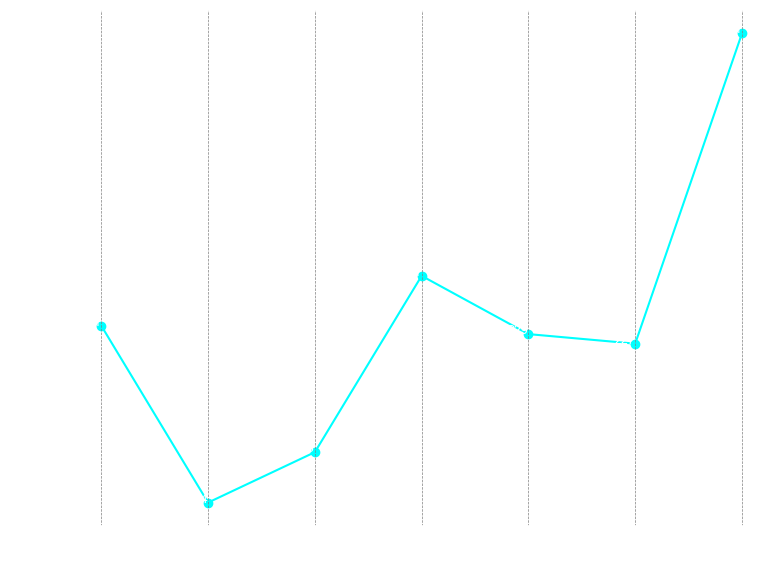

In [41]:
features = ['carrier', 'Airport_Route', 'stop', 'Days_to_Fly', 'from_hour', 'flight_duration_value', 'Holiday', 'Fly_WeekDay']

filtered_df = df[df['Trip_Type'] == 'One Way']

def get_annotation_interval(num_points, max_annotations=10):
    return max(1, num_points // max_annotations)

sns.set(style="darkgrid")

for feature in features:
    try:
        pdp_results = partial_dependence(pipeline, filtered_df, [feature])
        pdp_values = pdp_results['average'][0]
        pdp_grid = pdp_results['grid_values'][0]
        
        transformed_pdp_values = np.exp(pdp_values)
        
        # Plot the transformed partial dependence plot
        plt.figure(figsize=(8, 6))
        plt.plot(pdp_grid, transformed_pdp_values, marker='o', color='cyan')
        
        # Set plot background to black
        plt.gca().set_facecolor('none')
        plt.gcf().set_facecolor('none')
        
        # Determine annotation interval for x-axis labels
        x_annotation_interval = get_annotation_interval(len(pdp_grid), max_annotations=10)
        
        # Set x-axis ticks and labels to reduce clutter
        visible_x_ticks = pdp_grid[::x_annotation_interval]
        plt.xticks(visible_x_ticks, color='white')  # Change x-axis tick color to white

        # Annotate data points and add grid lines only when x-axis tick is visible
        for i, (x, y) in enumerate(zip(pdp_grid, transformed_pdp_values)):
            if x in visible_x_ticks:
                plt.text(x, y, f'{int(y)}', fontsize=9, ha='right', color='white')  # Change annotation color to white
                plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)

      
        plt.xlabel(feature, color='white')  # Change x-axis label color to white
        plt.ylabel('Predicted Price', color='white')  # Change y-axis label color to white
        plt.yticks(color='white') 
        plt.grid(False)  # Disable default grid
        print(f'saving {feature}')
        plt.tight_layout()
        plt.savefig(insights_plot_path + f'one_way_{feature}.png')
        plt.show()
    except MemoryError:
        print(f"MemoryError: Skipping feature {feature} due to memory constraints.")
    except Exception as e:
        print(f"Error: {e} encountered while processing feature {feature}.")

saving carrier


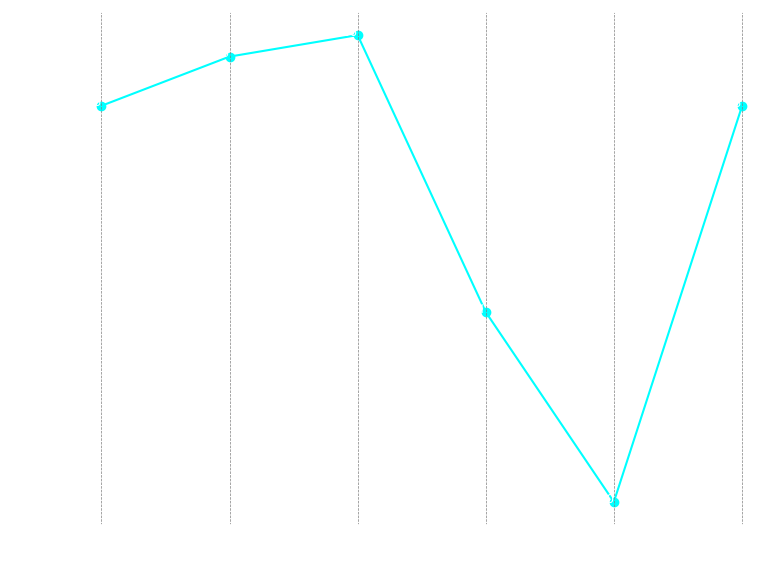

saving Airport_Route


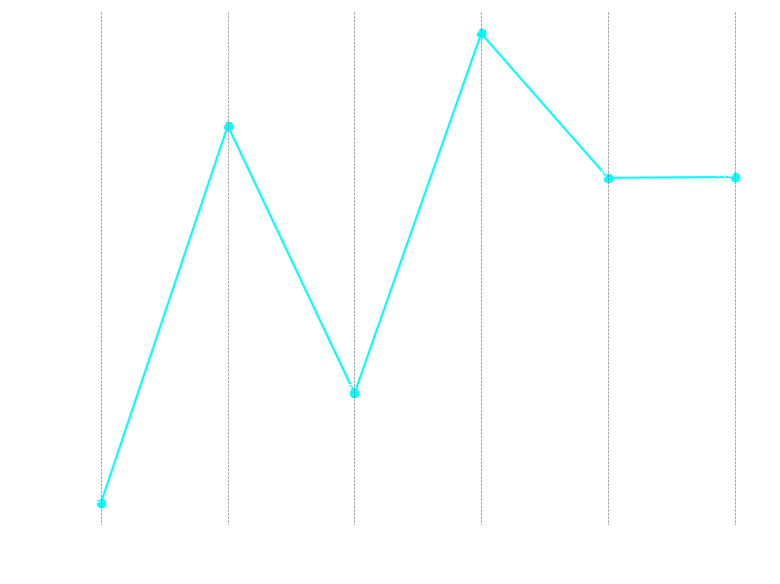

saving stop


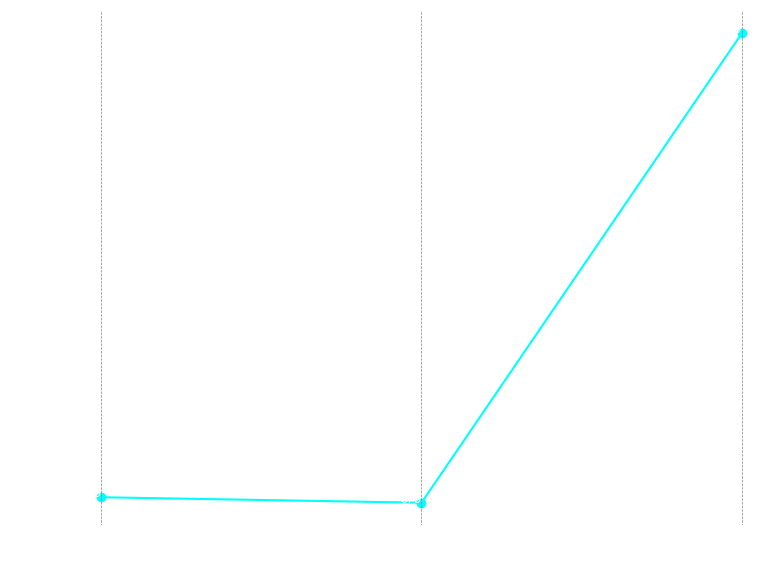

saving Days_to_Fly


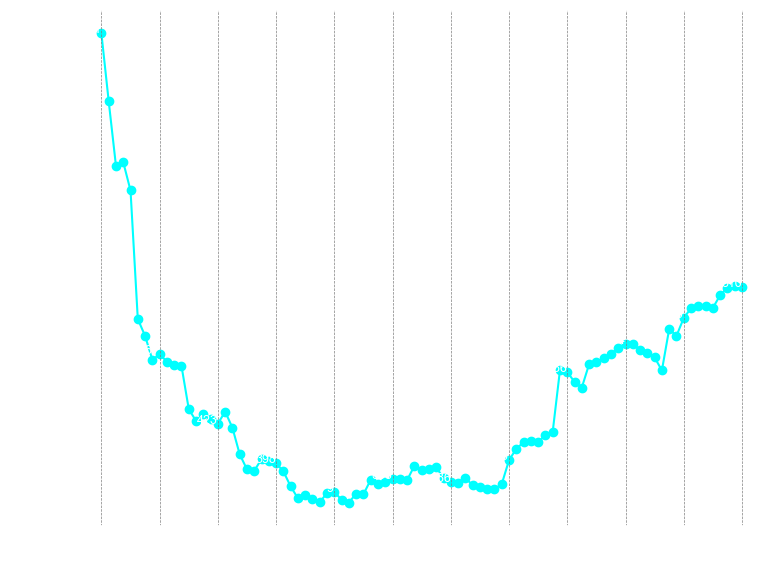

saving from_hour


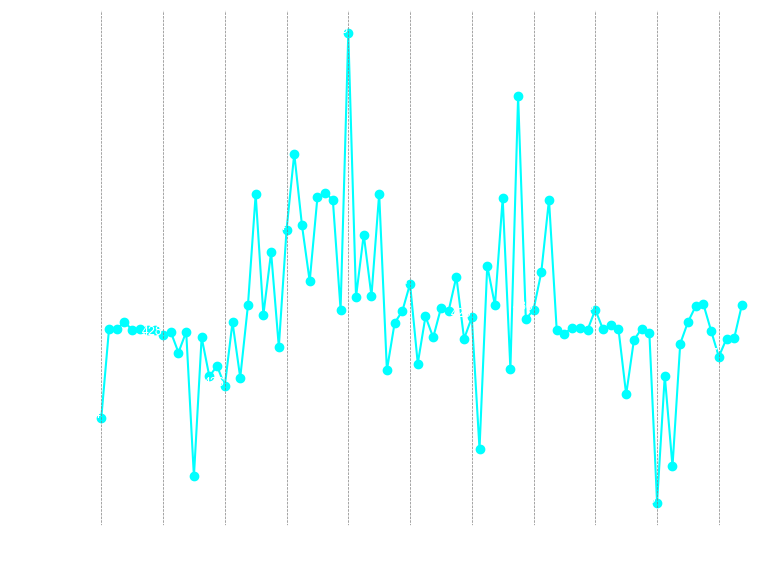

saving flight_duration_value


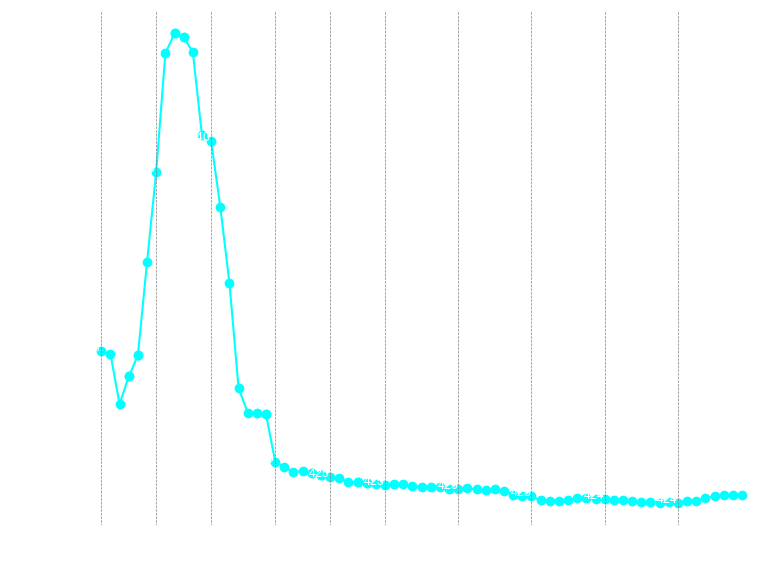

saving Holiday


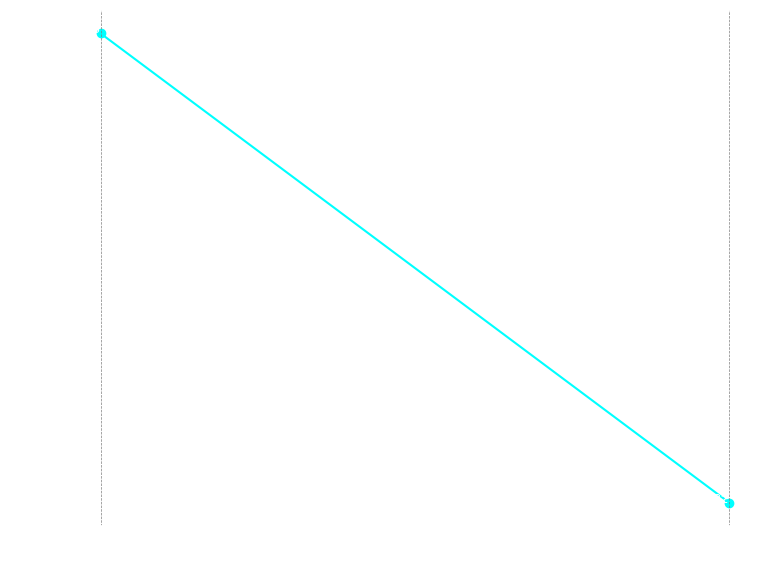

saving Fly_WeekDay


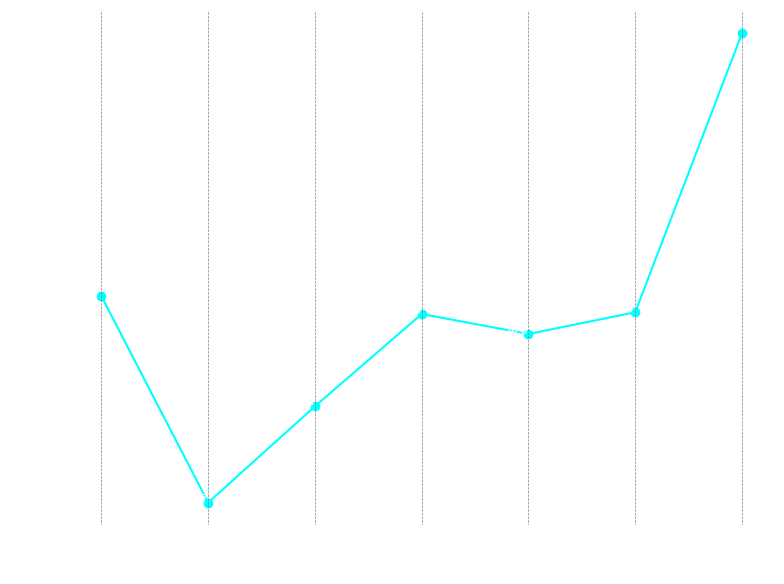

saving round_trip_duration


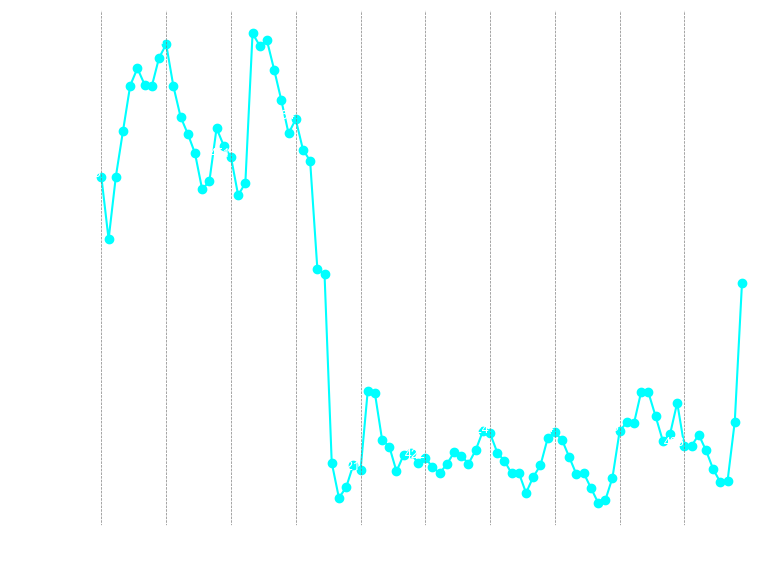

In [42]:
# Assuming 'pipeline' is your fitted model pipeline and 'df' is your dataframe
features = ['carrier', 'Airport_Route', 'stop', 'Days_to_Fly', 'from_hour', 'flight_duration_value', 'Holiday', 'Fly_WeekDay','round_trip_duration']

# Filter the dataframe for 'One Way' trips
filtered_df = df[df['Trip_Type'] == 'Rounds Trip']

# Function to determine annotation interval based on the number of points
def get_annotation_interval(num_points, max_annotations=10):
    return max(1, num_points // max_annotations)

sns.set(style="darkgrid")

# Loop through each feature and create the PDP plot
for feature in features:
    try:
        # Generate partial dependence for the current feature using the filtered dataframe
        pdp_results = partial_dependence(pipeline, filtered_df, [feature])
        
        # Extract partial dependence values
        pdp_values = pdp_results['average'][0]
        pdp_grid = pdp_results['grid_values'][0]
        
        # Transform the PDP values from log scale to the original scale
        transformed_pdp_values = np.exp(pdp_values)
        
        # Plot the transformed partial dependence plot
        plt.figure(figsize=(8, 6))
        plt.plot(pdp_grid, transformed_pdp_values, marker='o', color='cyan')

        plt.gca().set_facecolor('none')
        plt.gcf().set_facecolor('none')        
        
        # Determine annotation interval for x-axis labels
        x_annotation_interval = get_annotation_interval(len(pdp_grid), max_annotations=10)
        
        # Set x-axis ticks and labels to reduce clutter
        visible_x_ticks = pdp_grid[::x_annotation_interval]
        plt.xticks(visible_x_ticks, color='white')
        
        # Annotate data points and add grid lines only when x-axis tick is visible
        for i, (x, y) in enumerate(zip(pdp_grid, transformed_pdp_values)):
            if x in visible_x_ticks:
                plt.text(x, y, f'{int(y)}', fontsize=9, ha='right', color='white')
                plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)

        plt.xlabel(feature, color='white')
        plt.ylabel('Predicted Price', color='white')
        plt.yticks(color='white') 
        plt.grid(False)  # Disable default grid
        print(f'saving {feature}')
        plt.tight_layout()
        plt.savefig(insights_plot_path + f'round_trip_{feature}.png')
        plt.show()
    except MemoryError:
        print(f"MemoryError: Skipping feature {feature} due to memory constraints.")
    except Exception as e:
        print(f"Error: {e} encountered while processing feature {feature}.")